# Analyze Taylor Swift Lyrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import nltk
import re, random
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict, deque

### 1. Load the dataset


In [2]:
# load dataset
url = "https://drive.google.com/uc?export=download&id=1EgcYmrfEJs8MT2ktRxrhimr12ENj9J0T"
lyrics = pd.read_csv(url)

#inspect the first few rows
lyrics.head()


,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5


In [3]:
#get info about the DataFrame
lyrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9370 entries, 0 to 9369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9370 non-null   object
 1   track_title  9370 non-null   object
 2   track_n      9370 non-null   int64 
 3   lyric        9370 non-null   object
 4   line         9370 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 366.1+ KB


### 2. Add essential data

In [4]:
# get a list of all the albums in this collection
lyrics['album_name'].unique().tolist()


['Fearless (Taylor’s Version)',
 'Red (Deluxe Edition)',
 '1989 (Deluxe)',
 'midnights',
 'midnights (3am edition)',
 'reputation',
 'Taylor Swift',
 'folklore (deluxe version)',
 'Lover',
 'evermore (deluxe version)',
 'Speak Now (Deluxe)']

In [5]:
# map the name of the album to the year it was released
def album_release(row):
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    elif 'midnights' in row['album_name']:
        return '2022'
    return 'No Date'

# apply the function to the album
lyrics['release_year'] = lyrics.apply(album_release, axis=1)

# inspect the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,release_year
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008


### 3. Clean the lyric text

In [6]:
#lowercase
lyrics['clean_lyric']=lyrics['lyric'].str.lower()

#remove punctuation
lyrics['clean_lyric'] = lyrics['clean_lyric'].str.replace(r'[^\w\s]', '', regex=True)

In [7]:
#remove stopwords
#create a small list of English stop words
stop = ['the', 'a', 'this', 'that', 'to', 'is', 'am', 'was', 'were', 'be', 'being', 'been']

#clean the lyric text
lyrics['clean_lyric'] = lyrics['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [8]:
# inspect the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,release_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah


### 4. Find keyword mentions

In [9]:
#create a new column to reflect if the lyrics contain midnight
lyrics['Midnight']=lyrics['clean_lyric'].str.contains('midnight')
print (lyrics['Midnight'].sum())

20


### 5. Expand the keyword list

In [10]:
#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

In [11]:
#create a regular expression string for each list of words
night_regex = '|'.join(night)
day_regex = '|'.join(day)
time_regex = '|'.join(time)

#create a new column for each category of words
lyrics['Night'] = lyrics['clean_lyric'].str.contains(night_regex, regex=True)
lyrics['Day'] = lyrics['clean_lyric'].str.contains(day_regex, regex=True)
lyrics['Time'] = lyrics['clean_lyric'].str.contains(time_regex, regex=True)

#count the number of times each category of word appears in the lyrics
Counts_Night = (lyrics['Night'].sum())
Counts_Day = (lyrics['Day'].sum())
Counts_Time = (lyrics['Time'].sum())

#print the count of each word category
print ("Night words:", Counts_Night)
print ("Day words:", Counts_Day)
print ("Time words:", Counts_Time)


Night words: 287
Day words: 387
Time words: 35


In [12]:
#inspect the first few rows
lyrics.head()


,album_name,track_title,track_n,lyric,line,release_year,clean_lyric,Midnight,Night,Day,Time
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False


Taylor Swift has referenced time alot, there'are enough mentions for us to potentially spot some trends. Also, she has mentioned day far more than night.

### 6. Visualize how Taylor Swift's mentions of time have changed over time.

In [13]:
#create a new dataframe for yearly mentions that groups mentions by year
print (lyrics.head())
yearly_mentions = lyrics.groupby('release_year').sum().reset_index()

print(yearly_mentions)

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line release_year  \
0                    There's something 'bout the way     1         2008   
1             The street looks when it's just rained     2         2008   
2  There's a glow off the pavement, you walk me t...     3         2008   
3  And you know I wanna ask you to dance right there     4         2008   
4             In the middle of the parking lot, yeah     5         2008   

                                      clean_lyric  Midnight  Night    Day  \
0                       theres somethin

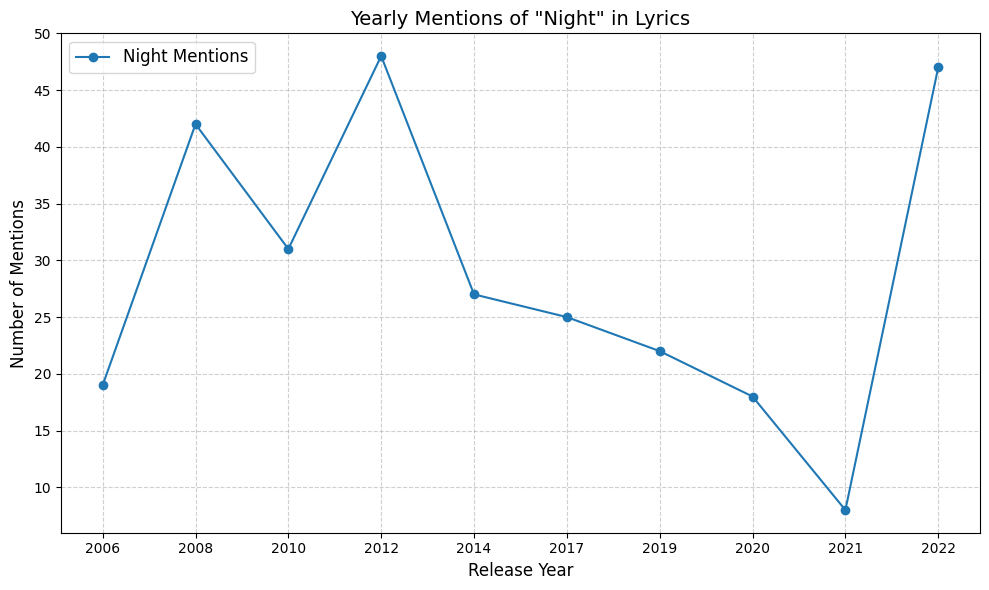

In [14]:
#plot the mentions of night over years
plt.figure(figsize=(10, 6))

# Plotting "Night" mentions by release_year
plt.plot(yearly_mentions['release_year'], yearly_mentions['Night'], marker='o', label='Night Mentions')

# Add labels, title, grid, and legend
plt.title('Yearly Mentions of "Night" in Lyrics', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.xticks(yearly_mentions['release_year'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

There is a rise of the yearly mentions of "Night" from 2006 to a peak in 2012, followed by a steady decline until 2021, and then a sharp resurgence in 2022 This pattern suggests a thematic shift over time, with night-related imagery being prominent during ehr earlier creative phases.


### 7. What albums are the most night/day focused?

In [15]:
#sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values(by='Night', ascending=False, inplace=True)
yearly_mentions.head()


,release_year,album_name,track_title,track_n,lyric,line,clean_lyric,Midnight,Night,Day,Time
3,2012,Red (Deluxe Edition)Red (Deluxe Edition)Red (D...,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,im walking fast through traffic lightsbusy str...,1,48,53,7
9,2022,midnightsmidnightsmidnightsmidnightsmidnightsm...,lavendar hazelavendar hazelavendar hazelavenda...,10553,Meet me at midnightStaring at the ceiling with...,27345,meet me at midnightstaring at ceiling with you...,11,47,24,0
1,2008,Fearless (Taylor’s Version)Fearless (Taylor’s ...,Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,theres something bout waystreet looks when its...,0,42,65,20
2,2010,Speak Now (Deluxe)Speak Now (Deluxe)Speak Now ...,MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,you in college working parttime waiting tables...,0,31,53,4
4,2014,1989 (Deluxe)1989 (Deluxe)1989 (Deluxe)1989 (D...,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,walking through crowd village aglowkaleidoscop...,2,27,41,0


In [16]:
#sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values(by='Day', ascending=False, inplace=True)
yearly_mentions.head()

,release_year,album_name,track_title,track_n,lyric,line,clean_lyric,Midnight,Night,Day,Time
1,2008,Fearless (Taylor’s Version)Fearless (Taylor’s ...,Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,theres something bout waystreet looks when its...,0,42,65,20
3,2012,Red (Deluxe Edition)Red (Deluxe Edition)Red (D...,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,im walking fast through traffic lightsbusy str...,1,48,53,7
2,2010,Speak Now (Deluxe)Speak Now (Deluxe)Speak Now ...,MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,you in college working parttime waiting tables...,0,31,53,4
6,2019,LoverLoverLoverLoverLoverLoverLoverLoverLoverL...,I Forgot That You ExistedI Forgot That You Exi...,8813,How many days did I spend thinking'Bout how yo...,25741,how many days did i spend thinkingbout how you...,0,22,46,0
4,2014,1989 (Deluxe)1989 (Deluxe)1989 (Deluxe)1989 (D...,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,walking through crowd village aglowkaleidoscop...,2,27,41,0


In [17]:
#sort both dataframes by year
yearly_mentions.sort_values(by='release_year', ascending=True, inplace=True)

### 8. Compare day to night mentions

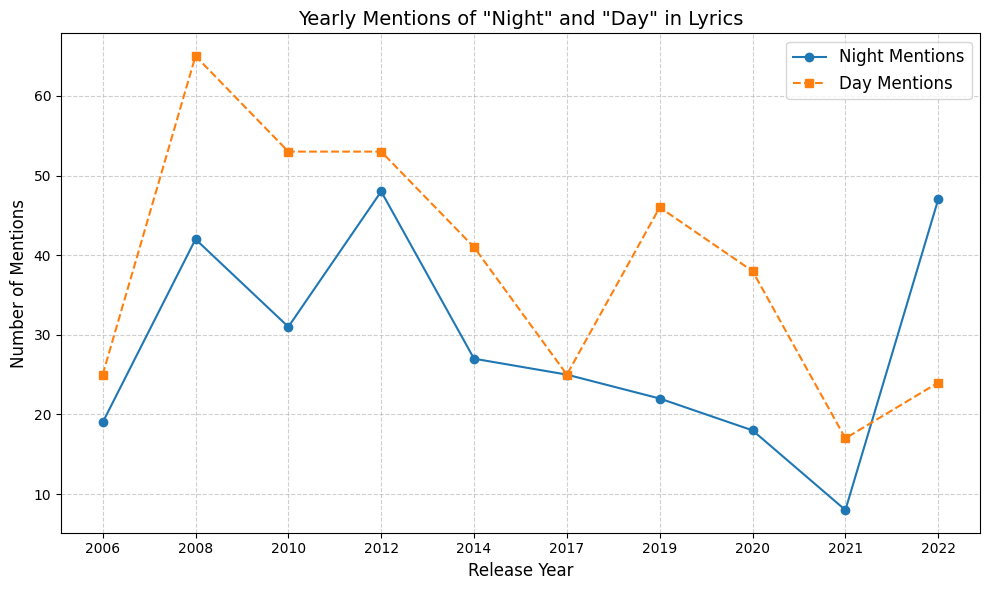

In [18]:
#create a plot with one line showing number of night references by year
#and another line with the number of day references by year

# Plotting the "Night" and "Day" mentions by year
plt.figure(figsize=(10, 6))

# Plot Night mentions
plt.plot(yearly_mentions['release_year'], yearly_mentions['Night'], marker='o', label='Night Mentions')

# Plot Day mentions
plt.plot(yearly_mentions['release_year'], yearly_mentions['Day'], marker='s', label='Day Mentions', linestyle='--')

# Adding labels, title, and legend
plt.title('Yearly Mentions of "Night" and "Day" in Lyrics', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.xticks(yearly_mentions['release_year'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### 9. Position of day vs. night mentions within albums

In [19]:
#create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + lyrics['line']

#create a new DataFrame that is grouped by position
positional_mentions = lyrics.groupby('position').sum().reset_index()

Text(0.5, 1.0, 'Day vs. night Mentions by Album Position')

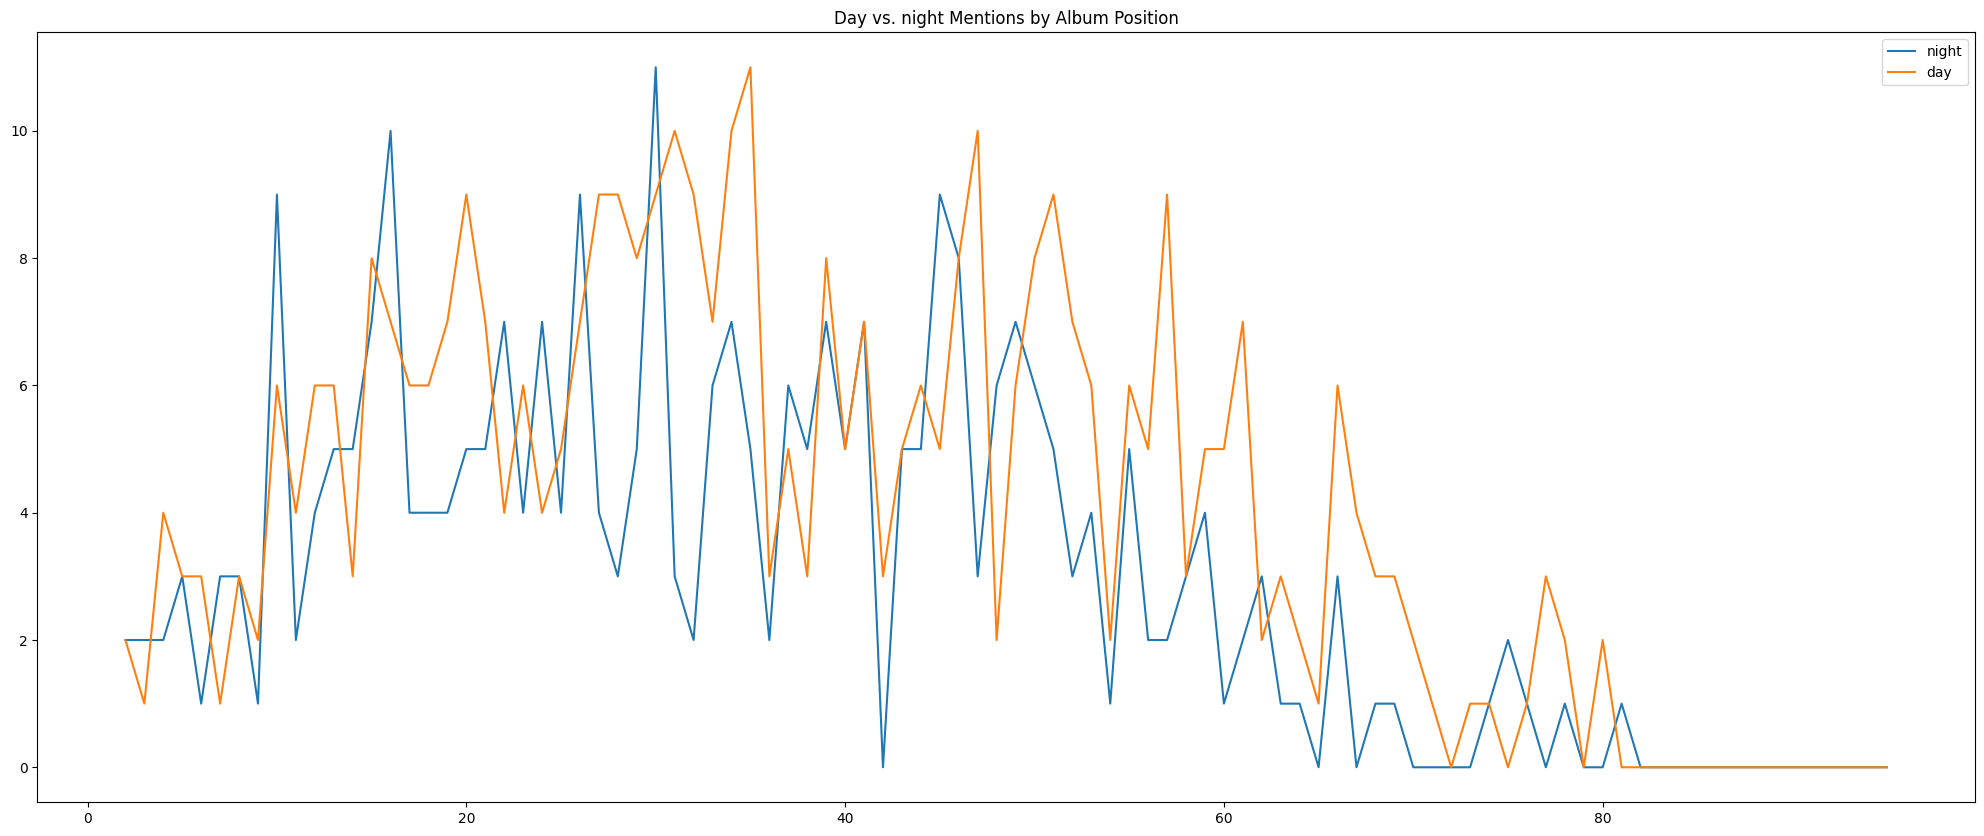

In [20]:
#increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(25, 10)

#create a plot with two lines to show frequency of day vs. night references by position in the album
plt.plot(positional_mentions['position'], positional_mentions['Night'], label = 'night')
plt.plot(positional_mentions['position'], positional_mentions['Day'], label = 'day')
plt.legend()
plt.title("Day vs. night Mentions by Album Position")

### 10. Tokenize the Lyrics


In [21]:
#tokenize the words in the clean_lyric column
lyrics['lyrics_tok'] = lyrics['clean_lyric'].str.split(' ')

In [22]:
#inspect the first few lines
lyrics.head()


,album_name,track_title,track_n,lyric,line,release_year,clean_lyric,Midnight,Night,Day,Time,position,lyrics_tok
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,2,"[theres, something, bout, way]"
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,3,"[street, looks, when, its, just, rained]"
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,4,"[theres, glow, off, pavement, you, walk, me, car]"
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,5,"[and, you, know, i, wanna, ask, you, dance, ri..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,6,"[in, middle, of, parking, lot, yeah]"


In [23]:
#what words overall are the most frequently used words
#create a list of all the words in the lyrics_tok column
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

#use the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)

#sort the word frequencies to find out the most common words she's used.
word_frequency = word_frequency.most_common()

#call the word frequency
print(word_frequency)


[('you', 3061), ('i', 2911), ('and', 1844), ('me', 1153), ('it', 1030), ('in', 1003), ('my', 927), ('your', 689), ('of', 667), ('all', 590), ('but', 581), ('im', 568), ('like', 552), ('on', 539), ('we', 538), ('know', 477), ('so', 454), ('oh', 447), ('its', 444), ('dont', 433), ('when', 417), ('never', 384), ('just', 374), ('youre', 367), ('for', 348), ('with', 332), ('love', 324), ('now', 321), ('what', 320), ('up', 305), ('out', 287), ('time', 286), ('cause', 283), ('if', 276), ('at', 276), ('back', 276), ('no', 239), ('are', 230), ('one', 222), ('do', 220), ('down', 218), ('got', 214), ('say', 212), ('see', 211), ('think', 202), ('they', 197), ('baby', 191), ('want', 189), ('can', 188), ('go', 188), ('not', 177), ('come', 175), ('could', 174), ('wanna', 170), ('have', 169), ('there', 168), ('right', 166), ('yeah', 166), ('ill', 165), ('he', 165), ('cant', 164), ('said', 158), ('ever', 150), ('get', 145), ('would', 144), ('thats', 142), ('had', 140), ('look', 134), ('how', 133), ('st

As the result suggests, she is likely writing about relationships and her realtionships with others

### 11. Analyze Lyric Sentiment

In [24]:
#adds a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
#how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [26]:
#apply the sia method to the clean_lyric column with a lambda expression, transform the polarity dictionary into columns of the DataFrame
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1, inplace=True)


In [27]:
#inspect the first few rows
lyrics.head()


,album_name,track_title,track_n,lyric,line,release_year,clean_lyric,Midnight,Night,Day,Time,position,lyrics_tok,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,2,"[theres, something, bout, way]",0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,3,"[street, looks, when, its, just, rained]",0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,4,"[theres, glow, off, pavement, you, walk, me, car]",0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,5,"[and, you, know, i, wanna, ask, you, dance, ri...",0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,6,"[in, middle, of, parking, lot, yeah]",0.0,0.694,0.306,0.296


### 12. Corpus Sentiment Analysis

In [28]:
#calculate overall sentiment for pos, neg, sentiment
overall_sentiment_pos = lyrics['pos'].mean()
overall_sentiment_neg = lyrics['neg'].mean()
overall_sentiment_compound = lyrics['compound'].mean()

#print the overall sentiments
print(f"Overall Positive Sentiment: {overall_sentiment_pos}")
print(f"Overall Negative Sentiment: {overall_sentiment_neg}")
print(f"Overall Compound Sentiment: {overall_sentiment_compound}")

Overall Positive Sentiment: 0.13181568836712912
Overall Negative Sentiment: 0.08530672358591249
Overall Compound Sentiment: 0.051851504802561364


Text(0.5, 1.0, "Overall Sentimnet of Taylor Swift's Albums Over Time")

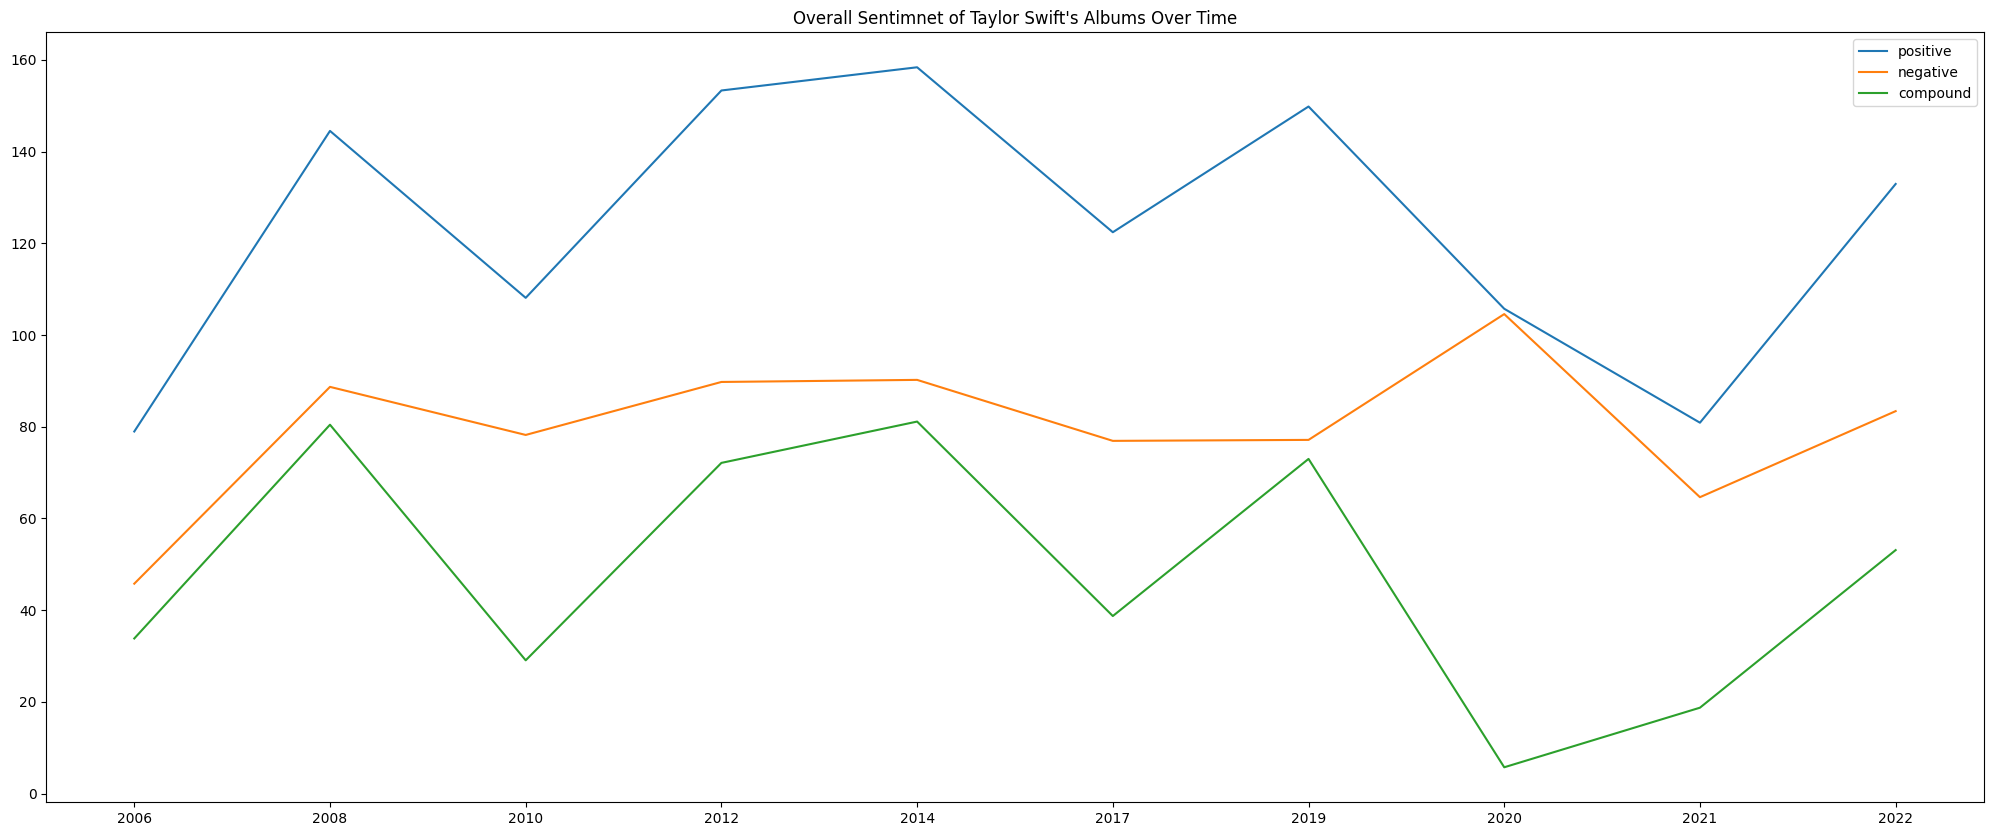

In [29]:
#create a new DataFrame using the groupby method for the album_year
yearly_sentiment = lyrics.groupby('release_year').sum().reset_index()

#visualize sentiment over time

#increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(25, 10)

#create a plot with three lines to show the overall sentimnet of her albums over time
plt.plot(yearly_sentiment['release_year'], yearly_sentiment['pos'], label = 'positive')
plt.plot(yearly_sentiment['release_year'], yearly_sentiment['neg'], label = 'negative')
plt.plot(yearly_sentiment['release_year'], yearly_sentiment['compound'], label = 'compound')
plt.legend()
plt.title("Overall Sentimnet of Taylor Swift's Albums Over Time")

### 13. Day or Night? Positive or Negative

In [30]:
#create a DataFrame filtered for only night mentions
night = lyrics[lyrics['Night']==True]

#create a DataFrame filtered for only day mentions
day = lyrics[lyrics['Day']==True]

#print the length of the night and day DataFrames
print ("night:", len(night))
print ("day:", len(day))

night: 287
day: 387


In [31]:
#calculate the sentiment of each day and night DataFrame from the compound values
night_sentiment = night['compound'].sum()
day_sentiment = day['compound'].sum()

#print the results
print ("Overall sentiment of night:", night_sentiment)
print ("Overall sentiment of day:", day_sentiment)

Overall sentiment of night: 19.7677
Overall sentiment of day: 26.58


# Generate new lyrics, based on Taylor Siwft's albums up to 2022, using MarkovChain

In [32]:
lyrics.head(10)

,album_name,track_title,track_n,lyric,line,release_year,clean_lyric,Midnight,Night,Day,Time,position,lyrics_tok,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,2,"[theres, something, bout, way]",0.000,1.000,0.000,0.0000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,3,"[street, looks, when, its, just, rained]",0.000,1.000,0.000,0.0000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,4,"[theres, glow, off, pavement, you, walk, me, car]",0.000,1.000,0.000,0.0000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,5,"[and, you, know, i, wanna, ask, you, dance, ri...",0.000,1.000,0.000,0.0000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,6,"[in, middle, of, parking, lot, yeah]",0.000,0.694,0.306,0.2960
5,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"Oh, yeah",6,2008,oh yeah,False,False,False,False,7,"[oh, yeah]",0.000,0.312,0.688,0.2960
6,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"We're driving down the road, I wonder if you know",7,2008,driving down road i wonder if you know,False,False,False,False,8,"[driving, down, road, i, wonder, if, you, know]",0.000,1.000,0.000,0.0000
7,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,I'm trying so hard not to get caught up now,8,2008,im trying so hard not get caught up now,False,False,False,False,9,"[im, trying, so, hard, not, get, caught, up, now]",0.189,0.811,0.000,-0.2183
8,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"But you're just so cool, run your hands throug...",9,2008,but youre just so cool run your hands through ...,False,False,False,False,10,"[but, youre, just, so, cool, run, your, hands,...",0.000,0.715,0.285,0.6107
9,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,Absent-mindedly making me want you,10,2008,absentmindedly making me want you,False,False,False,False,11,"[absentmindedly, making, me, want, you]",0.000,0.755,0.245,0.0772


In [33]:
class MarkovChain:
    def __init__(self):
        self.lookup_dict = defaultdict(list)
        self._seeded = False
        self.__seed_me()

    def __seed_me(self, rand_seed=None):
        if self._seeded is not True:
            try:
                if rand_seed is not None:
                    random.seed(rand_seed)
                else:
                    random.seed()
                self._seeded = True
            except NotImplementedError:
                self._seeded = False

    def add_document(self, str):
        preprocessed_list = self._preprocess(str)
        pairs = self.__generate_tuple_keys(preprocessed_list)
        for pair in pairs:
            self.lookup_dict[pair[0]].append(pair[1])

    def _preprocess(self, str):
        cleaned = re.sub(r'\W+', ' ', str).lower()
        tokenized = cleaned.split()
        return tokenized

    def __generate_tuple_keys(self, data, n=3):
        if len(data) < n:
            return

        for i in range(len(data) - n + 1):
            yield tuple(data[i:i + n])

    def generate_text(self, max_length=50):
        context = deque()
        output = []
        if len(self.lookup_dict) > 0:
            self.__seed_me(rand_seed=len(self.lookup_dict))
            chain_head = [list(self.lookup_dict)[0]]
            context.extend(chain_head)

            while len(output) < (max_length - 1):
                next_choices = self.lookup_dict[context[-1]]
                if len(next_choices) > 0:
                    next_word = random.choice(next_choices)
                    context.append(next_word)
                    output.append(context.popleft())
                else:
                    break
            output.extend(list(context))
        return " ".join(output)

    def post_process(self, text):
        text = text.capitalize()

        if not text.endswith(('.', '!', '?')):
            text += '.'

        return text

# Initialize and train the model with lyrics
my_markov = MarkovChain()
for album, album_lyrics in lyrics.groupby('album_name')['clean_lyric']:
    full_album_lyrics = ' '.join(album_lyrics)
    my_markov.add_document(full_album_lyrics)

# Generate text and post-process it
generated_text = my_markov.generate_text(max_length=150)
processed_text = my_markov.post_process(generated_text)
print(processed_text)


Walking house in bathroom i miss sparklin nice baby like i fight love gap between methodist and i offending now and your first time again with your face in and ill big reputation ooh look what about times before you used call it off i had you turn around cold and theyre all we are foxes and ill yours cause karma breeze in pouring rain soaking blind hoping you aint for me i parkеd my head im mirrorball ill never lose you for you drive and you hear it seemed like all of me im begging for money on playground wont try never saint and said it off i wanna play id never gonna hate cause im no surprises disappointments close friends she should say hello and watch sun goes im still trying find yourself at me ooh ooh i know it turns out and all same all about you.


## Is the sentiment expressed in the new lyric positive or negative?

In [34]:
# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Example review
review = processed_text

# Get sentiment score
sentiment_score = sia.polarity_scores(review)

# Print sentiment scores
print("Compound Score:", sentiment_score['compound'])

# Interpretation
if sentiment_score['compound'] >= 0.05:
    print("Positive sentiment")
elif sentiment_score['compound'] <= -0.05:
    print("Negative sentiment")
else:
    print("Neutral sentiment")


Compound Score: 0.5656
Positive sentiment
